In [1]:
from pathlib import Path
import torch

Let's revisit the flowers dataset from the first lesson

In [2]:
from mads_datasets import DatasetFactoryProvider, DatasetType
from mltrainer.preprocessors import BasePreprocessor
import os
import shutil

# Define the directory
dir_path = 'C:/Users/jari/.cache/mads_datasets/flowers'

# Check if the directory exists
if os.path.exists(dir_path):
    # Delete the directory
    shutil.rmtree(dir_path)

preprocessor = BasePreprocessor()

flowersfactory = DatasetFactoryProvider.create_factory(DatasetType.FLOWERS)

streamers = flowersfactory.create_datastreamer(batchsize=256, preprocessor=preprocessor)

c:\codes\machine-learning-opdracht-jari-heeres\.venv\Lib\site-packages\pydantic\_internal\_fields.py:160: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\codes\machine-learning-opdracht-jari-heeres\.venv\Lib\site-packages\pydantic\_internal\_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
2024-06-03 14:36:25.378 | INFO     | mads_datasets.base:download_data:94 - Start download...
  0%|          | 0.00/229M [00:00<?, ?iB/s]2024-06-03 14:36:26.239 | INFO     | mads_datasets.datatools:get_file:105 - Downloading C:\Users\jari\.cache\mads_datasets\flowers\flowers.tgz
100%|██████████| 229M/229M [00:05<00:00, 44.4MiB/s] 
2024-06-03 14:36:31.389 | INFO     | mads_datasets.datatools:extract:128 - Unzipping C:\Users\jari\.cache\mads

In [3]:
from torchvision import datasets, transforms
from PIL import Image
import torchvision.transforms.functional as F

# Define the directory containing the images
data_dir = 'C:/Users/jari/.cache/mads_datasets/flowers/flower_photos'

# Define the transformations
transformations = [
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation((30,70)),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
]

# Apply each transformation to each image in each subdirectory
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_path = os.path.join(root, file)
            image = Image.open(image_path)
            for i, transform in enumerate(transformations):
                transformed_image = transform(image)
                # Convert the transformed image to a tensor and then back to a PIL Image
                transformed_image = transforms.ToTensor()(transformed_image)
                transformed_image = F.to_pil_image(transformed_image)
                # Save the transformed image
                transformed_image_path = os.path.join(root, f'transformed_{i}_' + file)
                transformed_image.save(transformed_image_path)

In [ ]:
train = streamers["train"]
valid = streamers["valid"]
print(train)
print(valid)
trainstreamer = train.stream()
validstreamer = valid.stream()

BasetDatastreamer: ImgDataset (imgsize (224, 224), #classes 5) (streamerlen 11)
BasetDatastreamer: ImgDataset (imgsize (224, 224), #classes 5) (streamerlen 2)


In [ ]:
train = streamers["train"]
valid = streamers["valid"]
print(train)
print(valid)
trainstreamer = train.stream()
validstreamer = valid.stream()

BasetDatastreamer: ImgDataset (imgsize (224, 224), #classes 5) (streamerlen 11)
BasetDatastreamer: ImgDataset (imgsize (224, 224), #classes 5) (streamerlen 2)


The FlowersDatasetFactory adds a transform function that will (at random) flip, scale, affine an image. For the model, this is a new image, so it needs to focus on the general patterns instead of pixels.

In [ ]:
batch = train.batchloop()
len(batch)

256

In [ ]:
X, y = next(trainstreamer)
X.shape, y.shape


(torch.Size([256, 3, 224, 224]), torch.Size([256]))

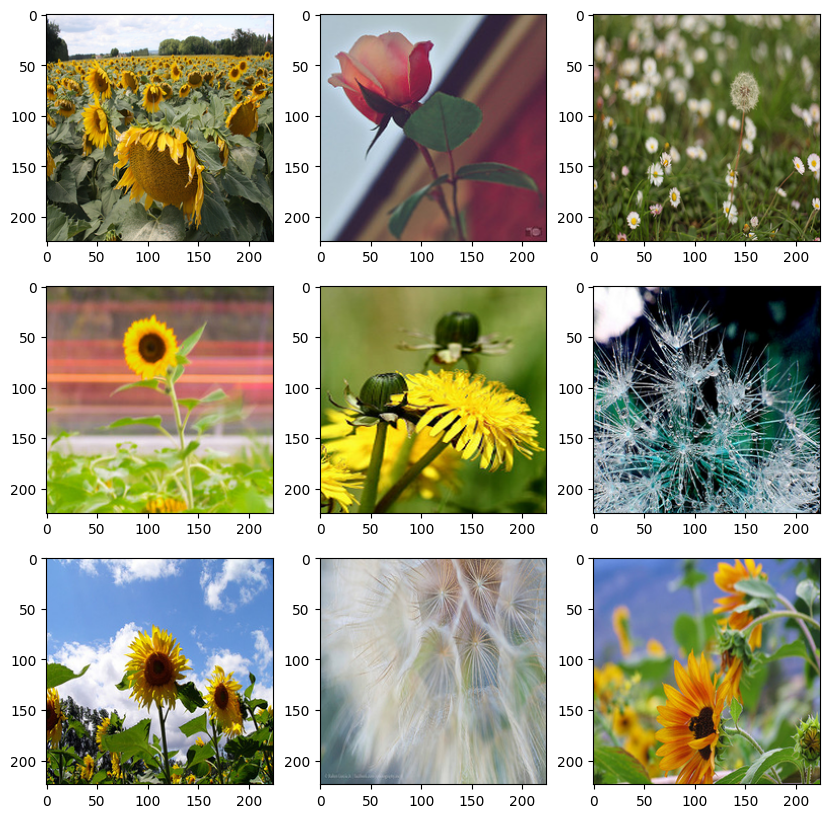

In [ ]:
import matplotlib.pyplot as plt
img = X.permute(0, 2, 3, 1)
fig, axs = plt.subplots(3, 3, figsize=(10,10))
axs = axs.ravel()
for i in range(9):
    axs[i].imshow(img[i])

Let's check the ranges, mean and std of a batch

In [ ]:
X.max(), X.min(), X.mean(), X.std()


(tensor(1.), tensor(0.), tensor(0.4094), tensor(0.3033))

Instead of building our own resnet, we will just download a pretrained version. This saves us many hours of training.

In [ ]:
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
resnet = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)


In [ ]:
ResNet18_Weights.DEFAULT

ResNet18_Weights.IMAGENET1K_V1

In [ ]:
yhat = resnet(X)
yhat.shape


torch.Size([256, 1000])

However, the resnet is trained for 1000 classes. We have just 5...

We will swap the last layer and retrain the model.

First, we freeze all pretrained layers:

In [ ]:
for name, param in resnet.named_parameters():
    param.requires_grad = False


If you study the resnet implementation on [github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L206) you can see that the last layer is named `.fc`, like this:

```
 self.fc = nn.Linear(512 * block.expansion, num_classes)
 ```

This is a Linear layer, mapping from 512 * block.expansion to num_classes.


so we will swap that for our own. To do so we need to figure out how many features go into the .fc layer.
We can retrieve the incoming amount of features for the current `.fc` with `.in_features`

In [ ]:
print(type(resnet.fc))
in_features = resnet.fc.in_features
in_features

<class 'torch.nn.modules.linear.Linear'>


512

Let's swap that layer with a small, two layer, neural network

In [ ]:
import torch.nn as nn

resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 5)
    # nn.ReLU(),
    # nn.Linear(128, 64),
    # nn.ReLU(),
    # nn.Linear(64, 5)
)


In [ ]:
yhat = resnet(X)
yhat.shape


torch.Size([256, 5])

So, we have a fully trained resnet, but we added two layers at the end that transforms everything into 5 classes.
These layers are random, so we need to train them for some epochs

In [ ]:
from mltrainer import metrics
accuracy = metrics.Accuracy()

This will take some time to train (about 4 min per epoch), you could scale down to amount of trainsteps to speed things up.

You will start with a fairly high learning rate (0.01), and if the learning stops, after patience epochs the learning rate gets halved.

In [ ]:
len(train), len(valid)

(11, 2)

In [ ]:
from mltrainer import Trainer, TrainerSettings, ReportTypes

settings = TrainerSettings(
    epochs=100,
    metrics=[accuracy],
    logdir="modellog",
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD],
    optimizer_kwargs= {'lr': 0.001, 'weight_decay': 1e-05},
    scheduler_kwargs= {'factor': 0.1, 'patience': 3},
    earlystop_kwargs= {'save': False, 'verbose': True, 'patience': 20},
)
print(settings)
trainer = Trainer(
    model=resnet,
    settings=settings,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau
    )

2024-06-03 11:39:57.566 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to modellog\20240603-113957
2024-06-03 11:39:57.567 | INFO     | mltrainer.trainer:__init__:70 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


epochs: 100
metrics: [Accuracy]
logdir: modellog
train_steps: 11
valid_steps: 2
reporttypes: [<ReportTypes.TENSORBOARD: 2>]
optimizer_kwargs: {'lr': 0.001, 'weight_decay': 1e-05}
scheduler_kwargs: {'factor': 0.1, 'patience': 3}
earlystop_kwargs: {'save': False, 'verbose': True, 'patience': 20}


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# note: this will be very slow!
trainer.loop()

100%|██████████| 11/11 [00:40<00:00,  3.70s/it]
2024-06-03 11:40:44.922 | INFO     | mltrainer.trainer:report:182 - Epoch 0 train 1.4329 test 5.0317 metric ['0.0000']
100%|██████████| 11/11 [00:40<00:00,  3.66s/it]t]
2024-06-03 11:41:31.659 | INFO     | mltrainer.trainer:report:182 - Epoch 1 train 0.9521 test 5.1650 metric ['0.0000']
2024-06-03 11:41:31.660 | INFO     | mltrainer.trainer:__call__:225 - best loss: 5.0317, current loss 5.1650.Counter 1/20.
100%|██████████| 11/11 [00:40<00:00,  3.65s/it]t]
2024-06-03 11:42:18.274 | INFO     | mltrainer.trainer:report:182 - Epoch 2 train 0.7088 test 3.9357 metric ['0.0000']
100%|██████████| 11/11 [00:39<00:00,  3.58s/it]t]
2024-06-03 11:43:04.156 | INFO     | mltrainer.trainer:report:182 - Epoch 3 train 0.5750 test 2.9075 metric ['0.0000']
100%|██████████| 11/11 [00:39<00:00,  3.56s/it]t]
2024-06-03 11:43:49.817 | INFO     | mltrainer.trainer:report:182 - Epoch 4 train 0.5007 test 2.7844 metric ['0.0000']
100%|██████████| 11/11 [00:39<00:0